In [79]:
import pandas as pd
import numpy as np 
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data import CryptoHistoricalDataClient, CryptoBarsRequest

from scipy.stats import norm, t, laplace


In [5]:
data_request = CryptoBarsRequest(
    symbol_or_symbols='BTC/USD', 
    start = datetime.datetime(2021, 1, 1), 
    end = datetime.datetime.now(), 
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)

client = CryptoHistoricalDataClient()
data = client.get_crypto_bars(request_params=data_request)

In [10]:
historical_bars_df = data.df.reset_index()
historical_bars_df['timestamp'] = pd.to_datetime(historical_bars_df['timestamp'])
historical_bars_df.drop(['symbol'], axis = 1, inplace=True)

In [12]:
# Saving to parquet file
historical_bars_df.to_parquet("btc_usd_1h.parquet")

In [15]:
historical_bars_df

,timestamp,open,high,low,close,volume,trade_count,vwap
0,2021-01-01 06:00:00+00:00,29255.710000,29338.250000,29153.550000,29234.150000,42.244289,1243.0,29237.240312
1,2021-01-01 07:00:00+00:00,29235.610000,29236.950000,28905.000000,29162.500000,34.506038,1070.0,29078.423185
2,2021-01-01 08:00:00+00:00,29162.500000,29248.520000,28948.860000,29076.770000,27.596804,1110.0,29091.465155
3,2021-01-01 09:00:00+00:00,29075.310000,29372.320000,29058.050000,29284.920000,20.694200,880.0,29248.730924
4,2021-01-01 10:00:00+00:00,29291.540000,29400.000000,29232.160000,29286.630000,16.617646,742.0,29338.609132
...,...,...,...,...,...,...,...,...
21949,2023-07-06 14:00:00+00:00,30433.970000,30433.970000,29687.300000,30121.800000,1.201926,27.0,29816.461087
21950,2023-07-06 15:00:00+00:00,30380.000000,30462.242050,30344.892600,30403.298294,0.450909,10.0,30418.564334
21951,2023-07-06 16:00:00+00:00,30390.160020,30464.462979,30290.155080,30309.304655,0.048879,12.0,30319.587032
21952,2023-07-06 17:00:00+00:00,30270.168097,30334.565525,30270.168097,30284.520260,0.016705,6.0,30313.803679


In this dataset, we have data taken at equal 1 hour intervals. The columns: 
* Open -> The price at the beginning of the period 
* High -> The highest price during the period
* Low -> The lowest price during the period
* Close -> The price at the end of the period
* Volume -> The amount of BTC traded over that interval 
* Trade count -> The amount of trades that were done over that period 
* VWAP -> The volume weighted average price which represents the price at which most bitcoins were transacted at over this time

In [23]:
historical_bars_df.describe().round(2)

,open,high,low,close,volume,trade_count,vwap
count,21954.00,21954.00,21954.00,21954.00,21954.00,21954.00,21954.00
mean,35330.19,35515.57,35130.61,35329.77,151.18,3415.63,35324.75
std,13415.76,13496.62,13329.05,13415.38,227.64,3819.80,13411.04
min,15627.65,15750.44,8200.00,15631.84,0.00,1.00,15659.03
25%,23060.94,23146.61,22964.43,23063.00,30.53,1399.25,23060.52
50%,33615.62,33840.00,33357.74,33613.44,68.03,2316.00,33607.83
75%,46067.15,46354.80,45777.55,46074.01,180.48,4051.75,46083.23
max,68633.87,69025.05,68463.36,68613.32,5213.69,110487.00,68602.53


In [20]:
historical_bars_df.isna().sum()

timestamp      0
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64

In [21]:
historical_bars_df.isnull().sum()

timestamp      0
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64

In [30]:
problem_bar = historical_bars_df[historical_bars_df['low'] == historical_bars_df['low'].min()]

We can see that there are no NA values and no null values. One odd thing is that the low price on 10/21/2021 at 11 am UTC is MUCH lower than the other values around it. We can impute that. I think that we can make it the minimum of the open and close. 

In [42]:
imputed_value = min(problem_bar['close'].values[0], problem_bar['open'].values[0])
historical_bars_df.iloc[7027, 3] = imputed_value

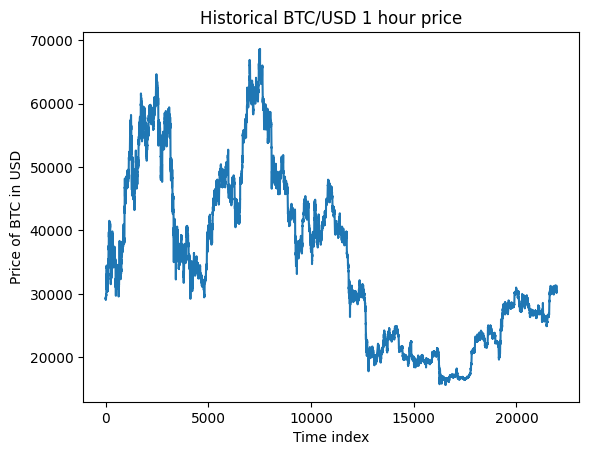

In [49]:
historical_bars_df['close'].plot()
plt.title("Historical BTC/USD 1 hour price")
plt.xlabel("Time index")
plt.ylabel("Price of BTC in USD")
plt.show()

What do the historical returns look like? 

In [61]:
returns = historical_bars_df['close'].pct_change().dropna()
returns.describe()

count    21953.000000
mean         0.000031
std          0.007633
min         -0.094516
25%         -0.002903
50%          0.000034
75%          0.002977
max          0.122647
Name: close, dtype: float64

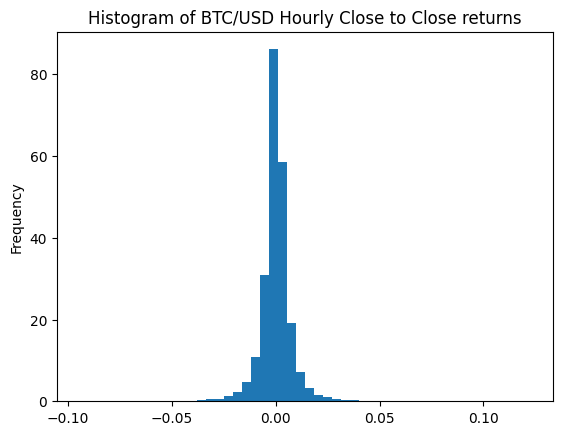

In [62]:
returns.plot(kind = 'hist', bins = 50, density = True)
plt.title("Histogram of BTC/USD Hourly Close to Close returns")
plt.show()

In [63]:
returns.mean()

3.074755344201531e-05

In [64]:

returns.std()

0.007632675741873547

In [65]:
norm.fit(returns)

(3.074755344201531e-05, 0.007632501898602366)

In [66]:
t.fit(returns)

(1.97895147787768, 1.5098934693031385e-05, 0.0036523623703493555)

In [67]:
laplace.fit(returns)

(3.3990288080154585e-05, 0.004802681714199978)

In [73]:
from dataclasses import dataclass

@dataclass
class NormFit:

    loc: float 
    scale: float

    @classmethod 
    def from_tuple(cls, params): 
        return cls(*params)
    

@dataclass 
class TFit: 

    df: float
    loc: float
    scale: float

    @classmethod
    def from_tuple(cls, params): 

        return cls(*params)
    
    def variance(self) -> float: 

        if self.df < 2: 
            return math.inf
        
        else: 
            return self.scale ** 2 * ((self.df)/(self.df - 2))
    


 
     



In [74]:
normal_fit = NormFit.from_tuple(norm.fit(returns))
t_fit = TFit.from_tuple(t.fit(returns))

In [76]:
t_fit

TFit(df=1.97895147787768, loc=1.5098934693031385e-05, scale=0.0036523623703493555)

In [78]:
normal_fit

NormFit(loc=3.074755344201531e-05, scale=0.007632501898602366)